# The Mountain Car Agent (MCA)

In order evaluate the efficacy of the algorithms, we focused on the graphs representing the `max-rewards` from the last `100 buckets`. This decision was based on previous analyses which suggested that this metric displayed the least noise. In distinguishing the performance differences among the algorithms, we pinpointed the one that consistently delivered superior results.

( for the results I suggest to look at the slides presentation of the models that are going to be avaible on lastminuteanalysis.com after the exam or in this github repository)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

# RL TRAINER (THE AGENT)

In [2]:
class RL_Trainer:
    def __init__(self, env_name, learning_rate=0.1, discount=0.95,
        show_every=50, generate_frames=False, frames_every=500,
        epsilon=1, start_epsilon_decaying=1, end_epsilon_decaying=500, discrete_os_size=[20, 20], q_table=None, learning_method='q_learning'):
        self.env = gym.make(env_name, render_mode='rgb_array')
        self.learning_rate = learning_rate
        self.discount = discount
        self.show_every = show_every
        self.frames_every = frames_every
        self.epsilon = epsilon
        self.start_epsilon_decaying = start_epsilon_decaying
        self.end_epsilon_decaying = end_epsilon_decaying
        self.epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)
        self.discrete_os_size = discrete_os_size
        self.discrete_os_win_size = (self.env.observation_space.high - self.env.observation_space.low)/discrete_os_size
        self.q_table = q_table if q_table is not None else np.random.uniform(low=-2, high=0, size=(discrete_os_size + [self.env.action_space.n]))
        self.ep_rewards = []
        self.aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
        self.frames_dir = 'frames'
        self.learning_method = learning_method
        self.generate_frames = generate_frames
        self.episode_steps = []

    def get_discrete_state(self, state):
        discrete_state = (state - self.env.observation_space.low)/self.discrete_os_win_size
        return tuple(discrete_state.astype(np.int64))
    
    def update_aggr_ep_rewards(self, episode):
        if len(self.ep_rewards) < self.show_every:
            average_reward = sum(self.ep_rewards) / len(self.ep_rewards)
        else:
            average_reward = sum(self.ep_rewards[-self.show_every:]) / self.show_every
        self.aggr_ep_rewards['ep'].append(episode)
        self.aggr_ep_rewards['avg'].append(average_reward)
        self.aggr_ep_rewards['max'].append(max(self.ep_rewards[-self.show_every:]))
        self.aggr_ep_rewards['min'].append(min(self.ep_rewards[-self.show_every:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {self.epsilon:>1.2f}')

    def q_learning(self, discrete_state, action, new_state, new_discrete_state, reward, done):
        if not done:
            max_future_q = np.max(self.q_table[new_discrete_state])
            current_q = self.q_table[discrete_state + (action,)]
            new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount * max_future_q)

            self.q_table[discrete_state + (action,)] = new_q

        elif new_state[0] >= self.env.goal_position:
            self.q_table[discrete_state + (action,)] = 0
    
    def sarsa(self, discrete_state, action, new_state, new_discrete_state, reward, done):
        new_action = np.argmax(self.q_table[new_discrete_state])
        if not done:
            current_q = self.q_table[discrete_state + (action,)]
            next_q = self.q_table[new_discrete_state + (new_action,)]
            new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount * next_q)

            self.q_table[discrete_state + (action,)] = new_q

        elif new_state[0] >= self.env.goal_position:
            self.q_table[discrete_state + (action,)] = 0
    
    def expected_sarsa(self, discrete_state, action, new_state, new_discrete_state, reward, done):
        if not done:
            expected_q = 0
            max_future_q = np.max(self.q_table[new_discrete_state])  # q_max
            current_q = self.q_table[discrete_state + (action,)]  # predict

            greedy_actions = 0
            for i in range(self.env.action_space.n):
                if self.q_table[new_discrete_state][i] == max_future_q:
                    greedy_actions += 1

            non_greedy_action_probability = self.epsilon / self.env.action_space.n  # Fix variable name
            greedy_action_probability = ((1 - self.epsilon) / greedy_actions) + non_greedy_action_probability

            for i in range(self.env.action_space.n):
                if self.q_table[new_discrete_state][i] == max_future_q:
                    expected_q += self.q_table[new_discrete_state][i] * greedy_action_probability
                else:
                    expected_q += self.q_table[new_discrete_state][i] * non_greedy_action_probability

            # The algorithm
            new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount * expected_q)
            self.q_table[discrete_state + (action,)] = new_q

        elif new_state[0] >= self.env.goal_position:
            self.q_table[discrete_state + (action,)] = 0

        
    def train(self, episodes=None):
        for episode in range(episodes):
            state,_ = self.env.reset()
            discrete_state = self.get_discrete_state(state)
            done = False
            episode_reward = 0
            frame = np.array([])
            steps = 0

            while not done:
                if np.random.random() > self.epsilon:
                    action = np.argmax(self.q_table[discrete_state])
                else:
                    action = np.random.randint(0, self.env.action_space.n)

                new_state, reward, done, _, _ = self.env.step(action)
                new_discrete_state = self.get_discrete_state(new_state)
                episode_reward += reward

                if episode_reward <= -200:
                    done = True

                if self.learning_method == 'q_learning':
                    self.q_learning(discrete_state, action, new_state, new_discrete_state, reward, done)
                elif self.learning_method == 'sarsa':
                    self.sarsa(discrete_state, action, new_state, new_discrete_state, reward, done)
                elif self.learning_method == 'expected_sarsa':
                    self.expected_sarsa(discrete_state, action, new_state, new_discrete_state, reward, done)

                discrete_state = new_discrete_state 

                if episode % self.frames_every == 0:
                    self.frame = self.env.render() 
                    img = Image.fromarray(self.frame)
                    img.save(os.path.join(self.frames_dir, f'frame_{episode}_{steps}.png'))
                
                steps += 1

            if self.end_epsilon_decaying >= episode >= self.start_epsilon_decaying:
                self.epsilon -= self.epsilon_decay_value

            self.ep_rewards.append(episode_reward)
            self.episode_steps.append(steps)

            if not episode % self.show_every: 
                self.update_aggr_ep_rewards(episode)

            if episode % self.show_every == 0:
                np.save(f"qtables/{episode}-qtable.npy", self.q_table)

        self.env.close()
    
    def plot_statistics(self):
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['avg'], label="average rewards")
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['max'], label="max rewards")
        plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['min'], label="min rewards")
        plt.legend(loc=4)
        plt.show()


# TESTING
Look if everything works

/Users/Giammi/miniconda3/envs/reinforcement/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:     0, average reward: -200.0, current epsilon: 1.00
Episode:    50, average reward: -200.0, current epsilon: 0.90
Episode:   100, average reward: -200.0, current epsilon: 0.80
Episode:   150, average reward: -200.0, current epsilon: 0.70
Episode:   200, average reward: -200.0, current epsilon: 0.60
Episode:   250, average reward: -200.0, current epsilon: 0.50
Episode:   300, average reward: -200.0, current epsilon: 0.40
Episode:   350, average reward: -200.0, current epsilon: 0.30
Episode:   400, average reward: -200.0, current epsilon: 0.20
Episode:   450, average reward: -200.0, current epsilon: 0.10
Episode:   500, average reward: -200.0, current epsilon: -0.00
Episode:   550, average reward: -198.9, current epsilon: -0.00
Episode:   600, average reward: -200.0, current epsilon: -0.00
Episode:   650, average reward: -200.0, current epsilon: -0.00
Episode:   700, average reward: -200.0, current epsilon: -0.00
Episode:   750, average reward: -200.0, current epsilon: -0.00
Ep

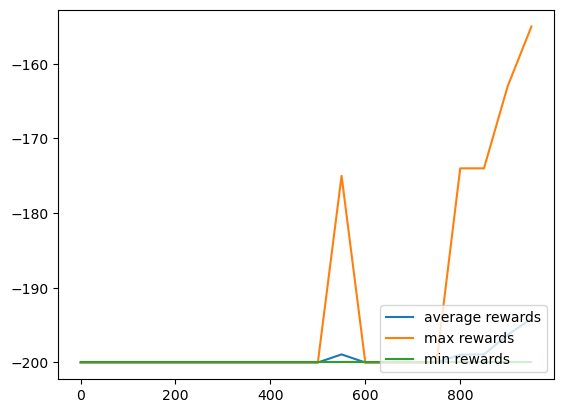

In [3]:
agent = RL_Trainer('MountainCar-v0', learning_method='q_learning')
agent.train(episodes=1000)
agent.plot_statistics()

# Running the experiment

/Users/Giammi/miniconda3/envs/reinforcement/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:     0, average reward: -200.0, current epsilon: 1.00
Episode:    50, average reward: -200.0, current epsilon: 0.99
Episode:   100, average reward: -200.0, current epsilon: 0.99
Episode:   150, average reward: -200.0, current epsilon: 0.98
Episode:   200, average reward: -200.0, current epsilon: 0.98
Episode:   250, average reward: -200.0, current epsilon: 0.97
Episode:   300, average reward: -200.0, current epsilon: 0.97
Episode:   350, average reward: -200.0, current epsilon: 0.96
Episode:   400, average reward: -200.0, current epsilon: 0.96
Episode:   450, average reward: -200.0, current epsilon: 0.95
Episode:   500, average reward: -200.0, current epsilon: 0.95
Episode:   550, average reward: -200.0, current epsilon: 0.94
Episode:   600, average reward: -200.0, current epsilon: 0.94
Episode:   650, average reward: -200.0, current epsilon: 0.93
Episode:   700, average reward: -200.0, current epsilon: 0.93
Episode:   750, average reward: -200.0, current epsilon: 0.92
Episode:

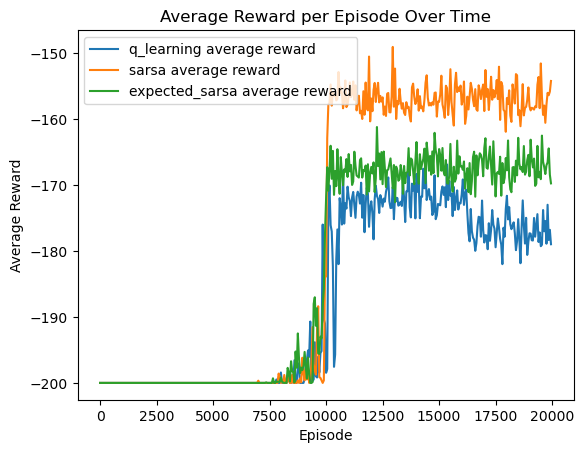

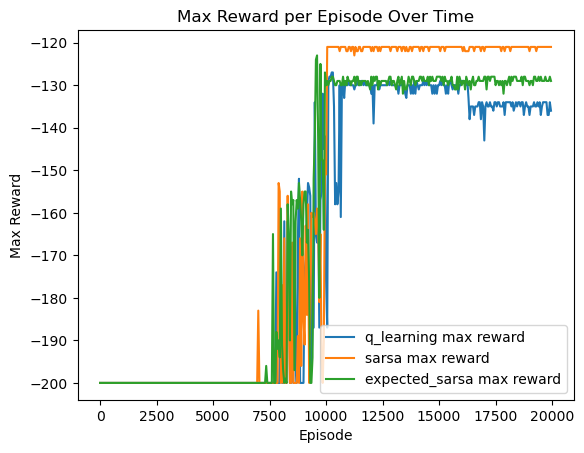

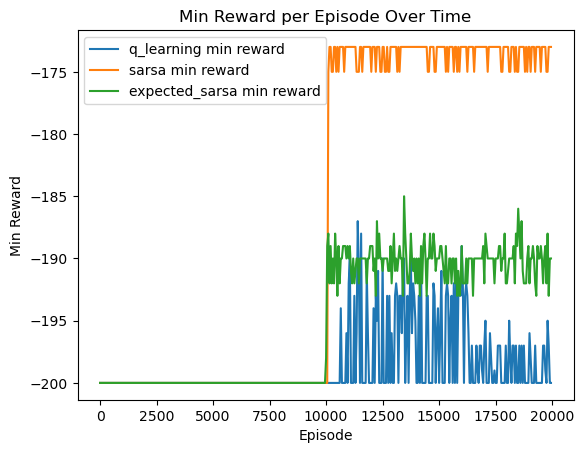

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [4]:
# function to train and plot instances of Q-Learning, SARSA, Expected SARSA

env_name="MountainCar-v0"
episodes=20000
methods = ['q_learning', 'sarsa', 'expected_sarsa']
rewards = {}

for method in methods:
    trainer = RL_Trainer(env_name, learning_rate=0.5, discount=0.99, show_every=50, generate_frames=False,
                            frames_every=500, epsilon=1, start_epsilon_decaying=1, end_epsilon_decaying=episodes//2,
                            discrete_os_size=[20, 20], q_table=None, learning_method=method)
                            
    trainer.train(episodes)
    rewards[method] = trainer.aggr_ep_rewards

# Generating plots
for method in methods:
    plt.plot(rewards[method]['ep'], rewards[method]['avg'], label=f"{method} average reward")
plt.title('Average Reward per Episode Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

for method in methods:
    plt.plot(rewards[method]['ep'], rewards[method]['max'], label=f"{method} max reward")
plt.title('Max Reward per Episode Over Time')
plt.xlabel('Episode')
plt.ylabel('Max Reward')
plt.legend()
plt.show()

for method in methods:
    plt.plot(rewards[method]['ep'], rewards[method]['min'], label=f"{method} min reward")
plt.title('Min Reward per Episode Over Time')
plt.xlabel('Episode')
plt.ylabel('Min Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))


# THE BOXPLOT

/Users/Giammi/miniconda3/envs/reinforcement/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:     0, average reward: -200.0, current epsilon: 1.00
Episode:   100, average reward: -200.0, current epsilon: 0.97
Episode:   200, average reward: -200.0, current epsilon: 0.93
Episode:   300, average reward: -200.0, current epsilon: 0.90
Episode:   400, average reward: -200.0, current epsilon: 0.87
Episode:   500, average reward: -200.0, current epsilon: 0.83
Episode:   600, average reward: -200.0, current epsilon: 0.80
Episode:   700, average reward: -200.0, current epsilon: 0.77
Episode:   800, average reward: -200.0, current epsilon: 0.73
Episode:   900, average reward: -200.0, current epsilon: 0.70
Episode:  1000, average reward: -200.0, current epsilon: 0.67
Episode:  1100, average reward: -200.0, current epsilon: 0.63
Episode:  1200, average reward: -200.0, current epsilon: 0.60
Episode:  1300, average reward: -200.0, current epsilon: 0.57
Episode:  1400, average reward: -200.0, current epsilon: 0.53
Episode:  1500, average reward: -200.0, current epsilon: 0.50
Episode:

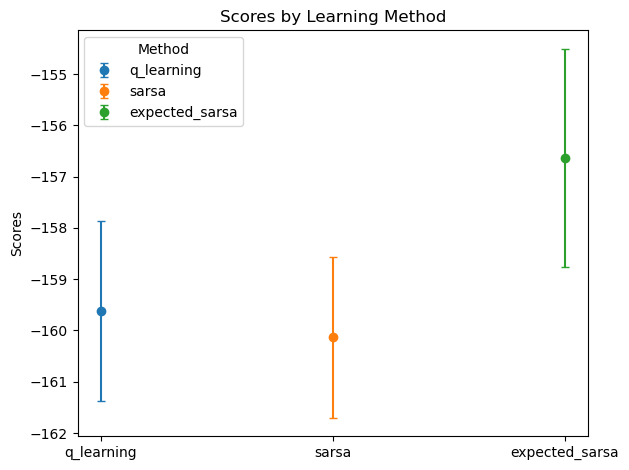

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 19 minutes with the following initialization

experiments = 10
episodes = 6000
last_episodes = 1000
labels = ['q_learning', 'sarsa', 'expected_sarsa']
results = {'q_learning': [], 'sarsa': [], 'expected_sarsa': []}

for method in ['q_learning', 'sarsa', 'expected_sarsa']:
    for ex in range(experiments):
        trainer = RL_Trainer(env_name="MountainCar-v0", learning_method=method, end_epsilon_decaying=episodes//2, show_every=100)  # Fixed this line
        trainer.train(episodes=episodes)
        #max_reward = np.max(trainer.ep_rewards[-last_episodes:])
        mean_reward = np.mean(trainer.aggr_ep_rewards['max'][-last_episodes:])
        # take max of mean
        results[method].append(mean_reward)

means = {method: np.mean(rewards) for method, rewards in results.items()}
variances = {method: np.var(rewards) for method, rewards in results.items()}
std_devs = {method: np.std(rewards) for method, rewards in results.items()}
std_vals = list(std_devs.values())

fig, ax = plt.subplots()

for i in range(len(labels)):
    ax.errorbar(labels[i], means[labels[i]], yerr=std_vals[i], capsize=3, fmt='o', label=labels[i])

ax.set_ylabel('Scores')
ax.set_title('Scores by Learning Method')
ax.set_xticks(range(len(labels)))  # Fixed this line
ax.set_xticklabels(labels)
ax.legend(title="Method")

fig.tight_layout()
plt.show()


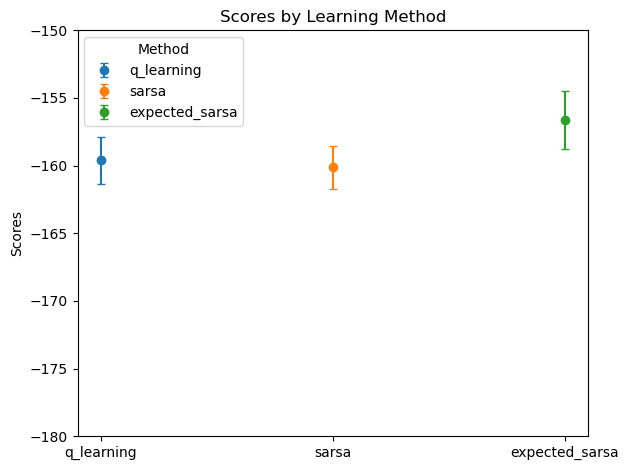

In [16]:
fig, ax = plt.subplots()

for i in range(len(labels)):
    ax.errorbar(labels[i], means[labels[i]], yerr=std_vals[i], capsize=3, fmt='o', label=labels[i])

ax.set_ylabel('Scores')
ax.set_title('Scores by Learning Method')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.legend(title="Method")

ax.set_ylim(-180,-150)  # Set y-axis limits

fig.tight_layout()
plt.show()
